In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
from sqlalchemy import inspect
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
print("Table name : measurement")
for column in columns:
    print(column["name"], column["type"])
print(" ")    
print("Table name : station")
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])


Table name : measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
 
Table name : station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
session.query(Station.station, Station.name).order_by(Station.station).all()

[('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US')]

In [12]:
session.query(Measurement.station, func.max(Measurement.date)).group_by(Measurement.station).order_by(Measurement.station).all()

[('USC00511918', '2015-10-30'),
 ('USC00513117', '2017-07-31'),
 ('USC00514830', '2017-08-23'),
 ('USC00516128', '2017-08-23'),
 ('USC00517948', '2017-07-31'),
 ('USC00518838', '2015-11-20'),
 ('USC00519281', '2017-08-18'),
 ('USC00519397', '2017-08-23'),
 ('USC00519523', '2017-08-23')]

last_date:2017-08-23, starting_date_of_year_ago:2016-08-23


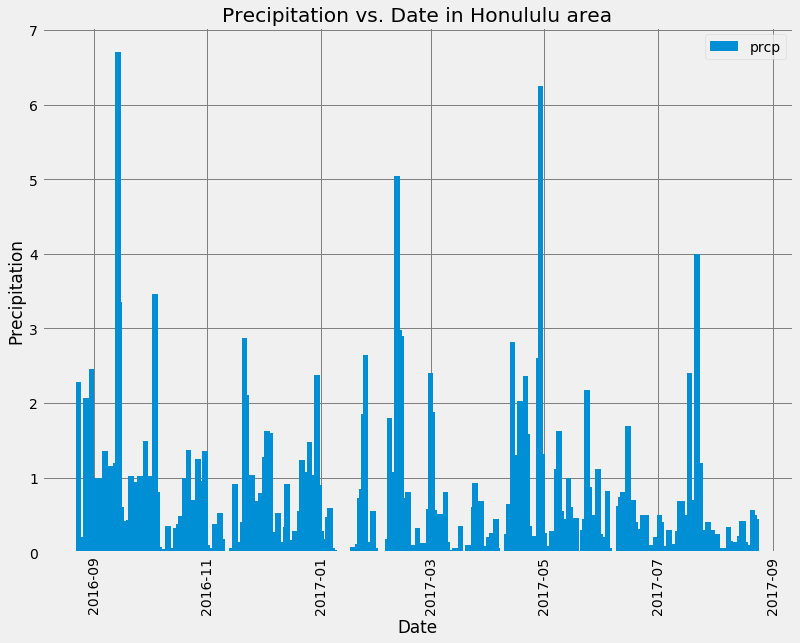

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
date_split = date_query[0].split("-")
last_date = dt.date(int(date_split[0]),int(date_split[1]), int(date_split[2]))
date_year_ago = last_date - dt.timedelta(days=365)
print(f'last_date:{last_date}, starting_date_of_year_ago:{date_year_ago}')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, func.max(Measurement.prcp)).\
    group_by(Measurement.date).filter(Measurement.date > date_year_ago).\
    order_by(Measurement.date.desc()).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.read_sql_query(precipitation_data,session.bind)
prcp_df.rename(columns={"max_1":"max_prcp"}, inplace=True)
prcp_df.set_index('date', inplace=True)
prcp_df.index=pd.to_datetime(prcp_df.index)

# # Sort the dataframe by date
# # Use Pandas Plotting with Matplotlib to plot the data
# fig, ax = plt.subplots(figsize=(15,7))
# prcp_df.plot(kind='bar', width=3, ax=ax)
# ax.set_ylabel("Precipitation")
# ax.set_xlabel("Date")
# ax.set_title("...")
# ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt='%Y-%m-%d'))
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.grid(axis='both', color='gray')
plt.figure(figsize=(12,9))
plt.bar(prcp_df.index, prcp_df.max_prcp, width=3, label='prcp')
plt.xticks(rotation=90)
plt.grid(axis='both', color='gray')
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend(loc='upper right')
plt.title('Precipitation vs. Date in Honululu area')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(prcp_df.describe())

         max_prcp
count  365.000000
mean     0.517288
std      0.829196
min      0.000000
25%      0.040000
50%      0.250000
75%      0.650000
max      6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
station_list = list(np.ravel(session.query(Measurement.station).distinct().all()))
station_list
print(f"The number of available stations are {len(station_list)}.")

The number of available stations are 9.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
list_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
             group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"Most active station is {list_active_stations[0][0]} with {list_active_stations[0][1]} rows.")

print("List of active stations are:")
for station in list_active_stations:
    print(f"Station {station[0]} with {station[1]} rows.")

Most active station is USC00519281 with 2772 rows.
List of active stations are:
Station USC00519281 with 2772 rows.
Station USC00519397 with 2724 rows.
Station USC00513117 with 2709 rows.
Station USC00519523 with 2669 rows.
Station USC00516128 with 2612 rows.
Station USC00514830 with 2202 rows.
Station USC00511918 with 1979 rows.
Station USC00517948 with 1372 rows.
Station USC00518838 with 511 rows.


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stat_station = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station == list_active_stations[0][0]).all()
print(f"The station {stat_station[0][0]} has {stat_station[0][1]} as lowest temperature recorded")
print(f"The station {stat_station[0][0]} has {stat_station[0][2]} as highest temperature recorded")
print(f"The station {stat_station[0][0]} has {round(stat_station[0][1],2)} as average temperature recorded")

The station USC00519281 has 54.0 as lowest temperature recorded
The station USC00519281 has 85.0 as highest temperature recorded
The station USC00519281 has 54.0 as average temperature recorded


('WAIHEE 837.5, HI US', 'USC00519281', 2772)
('2017-08-18',)
Station WAIHEE 837.5, HI US's last_date of observation is 2017-08-18, date_year_ago:2016-08-18


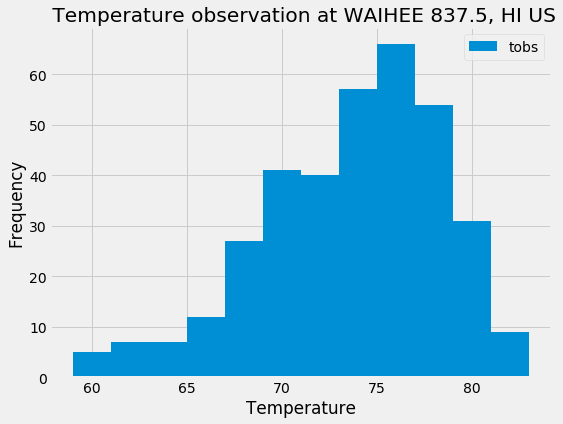

In [18]:
# Choose the station with the highest number of temperature observations.
high_station = session.query(Station.name, Measurement.station, func.count(Measurement.tobs)).\
             filter(Measurement.station == Station.station).\
             group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
print(high_station)

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
print(session.query(Measurement.date).order_by(Measurement.date.desc()).filter(Measurement.station == high_station[1]).first())
last_date = dt.date(2017,8,18)
date_year_ago = last_date - dt.timedelta(days=365)
print(f"Station {high_station[0]}'s last_date of observation is {last_date}, date_year_ago:{date_year_ago}")

data = session.query(Measurement.tobs).filter(Measurement.station == high_station[1]).\
        filter(Measurement.date > date_year_ago).statement
df2 = pd.read_sql_query(data, session.bind)
df2.hist(bins=12, label='tobs', figsize=(8,6))
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title(f" Temperature observation at {high_station[0]}")
plt.legend()
plt.show()

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
session.query(func.max(Measurement.date), func.min(Measurement.date)).all()

[('2017-08-23', '2010-01-01')]

In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# MY Trip is from 07/17 until 07/31
year_list = np.arange(2010, 2018, 1)
trip_start_date = [2017,7,17]
trip_end_date = [2017,7,31]
result_list = []
for year in year_list:
    result_list.append(calc_temps(dt.date(year, trip_start_date[1], trip_start_date[2]),dt.date(year, trip_end_date[1], trip_end_date[2])))

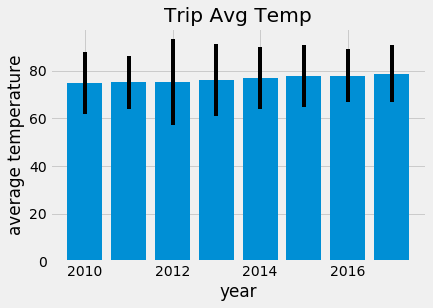

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_value = []
y_err = []
for i in range(len(result_list)):
    y_value.append(result_list[i][0][1])
    y_err.append(result_list[i][0][2]-result_list[i][0][0])
plt.bar(year_list, y_value,yerr=y_err)
plt.xlabel("year")
plt.ylabel("average temperature")
plt.title("Trip Avg Temp")
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
result = session.query(Measurement.station, func.round(func.sum(Measurement.prcp),2), Station.name, Station.latitude,Station.longitude, Station.elevation).\
    filter(Measurement.date>=dt.date(trip_start_date[0],trip_start_date[1],trip_start_date[2])).\
    filter(Measurement.date<=dt.date(trip_end_date[0],trip_end_date[1],trip_end_date[2])).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
print("Station, total amount of rainfall, Station Name, Station Lat, Station Lng, Station Elevation")
for i in range(len(result)):
    print(result[i])

Station, total amount of rainfall, Station Name, Station Lat, Station Lng, Station Elevation
('USC00516128', 11.1, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00519281', 1.97, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00514830', 1.93, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00513117', 1.26, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519523', 0.38, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00519397', 0.19, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00517948', 0.01, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
daily_normals("07-07")

[(69.0, 74.91071428571429, 82.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date="2020-07-17"
end_date = "2020-07-31"
start_split = start_date.split("-")
end_split = end_date.split("-")
# Use the start and end date to create a range of dates
dates = [dt.date(int(start_split[0]),int(start_split[1]),int(start_split[2])) + dt.timedelta(k) for k in range(int(end_split[2])-int(start_split[2]))]
# Stip off the year and save a list of %m-%d strings
month_day_list = []
for i in range(len(dates)):
    month_day_list.append(f"0{dates[i].month}-{dates[i].day}")
# Loop through the list of %m-%d strings and calculate the normals for each date
result_daily_normal=[]
for i in range(len(month_day_list)):
    result_daily_normal.append(np.array((daily_normals(month_day_list[i])[0])))

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# tmin, tavg, and tmax
result_df = pd.DataFrame(result_daily_normal)
result_df["trip_dates"] = month_day_list
result_df.rename(columns={0:"tmin", 1:"tavg", 2:"tmax"}, inplace=True)
result_df.set_index("trip_dates", inplace=True)
result_df.head()

,tmin,tavg,tmax
trip_dates,,,
07-17,70.0,76.301887,83.0
07-18,72.0,76.637931,83.0
07-19,68.0,75.890909,83.0
07-20,69.0,75.462963,82.0
07-21,69.0,76.924528,83.0


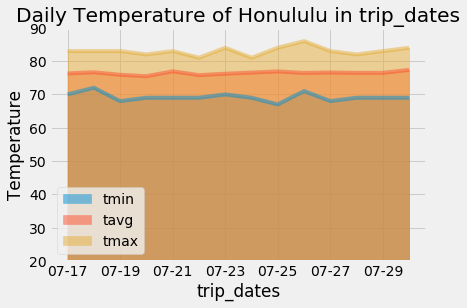

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
result_df.plot(kind='area', stacked=False)
plt.ylabel("Temperature")
plt.legend(loc="best")
plt.title("Daily Temperature of Honululu in trip_dates")
plt.ylim(20,90)
plt.show()
